In [61]:
from IPython.display import HTML
css_file = './custom.css'
HTML(open(css_file, "r").read())

# Principal Component Analysis (PCA)

© 2018 Daniel Voigt Godoy

## 1. Definition

Principal Component Analysis is a ***dimensionality reduction*** technique. It finds the ***hyperplane closest to the data*** and projects the data onto it.

What does it mean? It means it will find a ***transformation matrix*** that will make data points ***land in such a way it concentrates variance in fewer dimensions***.

We can think of data in the wild as ***information previously transformed*** by an ***unknown matrix*** and we want to turn it back to its ***original state***.

### 1.1 Example

We draw 30 random normal points (left plot) and ***scale*** them by a ***factor of 3 on the x axis*** (center plot). This is our ***original state***.

But then, for whatever reason, our data in the wild was observed ***as if it were rotated*** (right plot), the equivalent of the ***unknown matrix***. This is the ***data*** we have to work with. 

From ***this*** data, can we figure out its ***original state***? ***Yes***, we can!

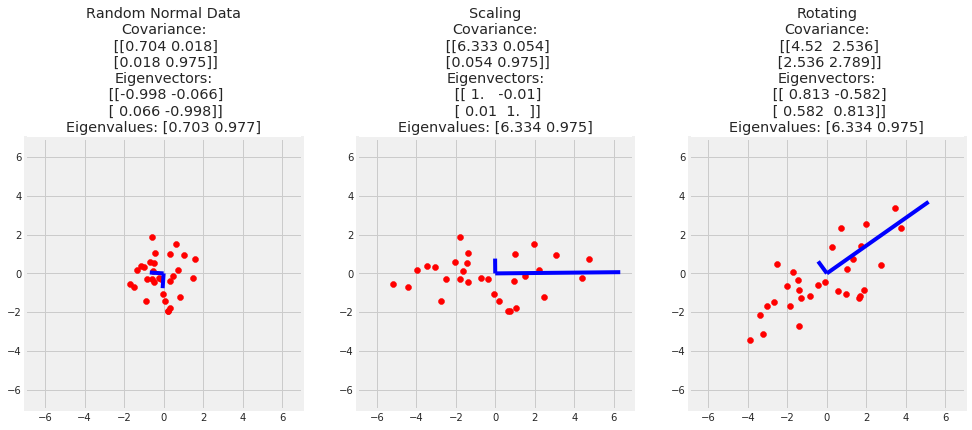

In [68]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

%matplotlib inline

np.random.seed(42)
X1 = np.random.randn(30, 2)
X2 = X1 * np.array((3, 1))
degrees = 35
rads = degrees / 180 * np.pi
rotation = np.array(((np.cos(rads), -np.sin(rads)), (np.sin(rads), np.cos(rads))))
X = np.matmul(X2, rotation.T)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
data = [X1, X2, X]
titles = ['Random Normal Data', 'Scaling', 'Rotating']
for a, d, t in zip(axes, data, titles):
    eigval, eigvec = np.linalg.eig(np.cov(d.T))
    df1=pd.DataFrame({'x': [0, eigvec[0, 0]*eigval[0]], 'y': [0, eigvec[1, 0]*eigval[0]]})
    df2=pd.DataFrame({'x': [0, eigvec[0, 1]*eigval[1]], 'y': [0, eigvec[1, 1]*eigval[1]]})
    a.plot('x', 'y', data=df1, linestyle='-', c='blue')
    a.plot('x', 'y', data=df2, linestyle='--', c='blue')    
    a.scatter(*d.T, c='r')
    a.set_title('{}\nCovariance:\n {}\nEigenvectors:\n {}\nEigenvalues: {}'.format(t, 
                                                                                  np.round((np.cov(d.T)), 3),
                                                                                  np.round(eigvec, 3),
                                                                                  np.round(eigval, 3)))
    a.set_xlim([-7, 7])
    a.set_ylim([-7, 7])

The 3 plots have some information attached: a ***covariance matrix*** and the ***eigenvectors and eigenvalues for the covariance matrix***.

The ***blue lines*** are the ***eigenvectors*** multiplied by their corresponding ***eigenvalues*** for sizing.

Before proceeding, try to answer these questions:

1. For the center plot (the original state):
    - how is the ***variance*** distributed? 
    - how does the ***variance*** relate to the ***eigenvalues***?


2. For the right plot (the data in the wild):
    - how is the ***variance*** distributed now?
    - how does the ***variance*** relate to the ***eigenvalues***? (hint: look at the ***diagonal*** of the covariances)


3. Comparing center and right plots' ***information***:
    - what do they have in common?

### 1.2 Algorithm

You probably guessed already that the ***eigenvectors and eigenvalues of the covariance matrix*** are ***key*** to the PCA algorithm.

They remain ***constant*** despite the data being ***rotated*** (which does ***not*** hold for the ***covariance matrix***).

Besides, the ***matrix of eigenvectors*** $W$ has an ***important property***:

$$
W^T \cdot W = I
$$

So, if we use $W^T$ as a ***transformation matrix*** and apply it to the ***matrix eigenvectors***, they will land on the ***basis vectors*** $I$.

In our example, this is the same as ***rotating the eigenvectors*** so they get aligned nicely to ***x*** and ***y*** axis.

Then, if we apply the $W^T$ ***transformation*** to our data, it will do the same! We're moving from ***data in the wild*** back to the ***original state***.

But there is actually more to it! You're not obliged to stick with the same number of dimensions - this is a dimensionality reduction technique, after all!

You can ***choose*** the ***eigenvectors*** with the ***largest eigenvalues*** and use a ***nonsquare transformation matrix*** $(W_r)^T \ $. This way, when you perform the transformation, you'll be ***projecting data into a lower dimensional space***.

In a nutshell:
- compute ***covariance matrix of data***
- compute ***eigenvectors and eigenvalues*** of the ***covariance matrix***
- choose ***largest eigenvalues*** and corresponding ***eigenvectors***
- assemble chosen eigenvectors into a ***nonsquare transformation matrix*** $(W_r)^T$
- ***apply the transformation*** to the data

### 1.3 How many dimensions to use?

There is no hard rule for it, but there are some options:

#### 1.3.1 Fixed

If you're using PCA to project data into a lower dimension to ***visualize*** it, it makes sense to pick a fixed value: 1, 2 or 3.

#### 1.3.2 Threshold

It is also common to use a ***threshold*** for the ***ratio of explained variance***.

What is that? It is the ***proportion of variance*** contained in the ***chosen eigenvectors***.

If you sum up ***all eigenvalues***, you have the ***total variance***. So, the increase in ***ratio of explained variance*** obtained for ***including an eigenvector i*** in your $W_r \ $ ***matrix*** is given by:

$$
ratio_i = \frac{\lambda_i}{\sum_j^n{\lambda_j}}
$$

Then you can add up the corresponding ratios until you reach your ***threshold***.

In our example:
$$
ratio_1 = \frac{\lambda_1}{\lambda_1 + \lambda_2} = \frac{6.334}{6.334+.975} = 0.8666
$$

It means that using the ***eigenvector*** associated with the ***eigenvalue 6.334*** will give us a ***1D projection*** that ***explains 86.66% of the variance***.

In this case:

$$
W_r =  \begin{bmatrix}
   0.813 \\
   0.582
 \end{bmatrix}
\\
(W_r)^T = \begin{bmatrix} 0.813 & 0.582 \end{bmatrix}
$$

#### 1.3.2 Elbow Rule

In the example, one of the components explains 86.66% of the variance, while the remaining component explains just 13.34%. It is very common to observe the ***concentration*** of explained variance in a ***handful*** of components.

Even if you have 10-dimensional data, it is very likely that the 3 or 4 largest components together explain 80% of the variance, for instance.

If you plot the ***ratios of explained variance*** in decreasing order, you'll get a figure like this:

![](https://blogs.sas.com/content/iml/files/2017/07/PCAbrokenstiick2.png)
<center>Source: Dimension reduction: Guidelines for retaining principal components (SAS)</center>

In the right plot, you can see that, at 4 components, the ***ratio gets flat***. This is the ***elbow***. So, following this rule of thumb, the result would be 4-dimensional.

### 1.4 PCA x SVD

It turns out PCA and SVD (Singular Value Decomposition) share some of the information. Although we're learning about PCA through ***eigen decomposition*** to understand it better, Scikit-Learn implements PCA using SVD under the hood for performance reasons.

![](https://cdn-images-1.medium.com/max/800/1*55ZIj421DemGyhYst3DHaw.png)
<center>Source: An easy introduction to unsupervised learning with 4 basic techniques<a href='https://towardsdatascience.com/an-easy-introduction-to-unsupervised-learning-with-4-basic-techniques-897cb81979fd'></a></center>

## 2. Experiment

Time to try it yourself!

There is a standard ***grid*** and it has the two ***eigenvectors*** from our example.

The plot on the right shows the ***variance*** associated with each axis. You can see that its values, 4.52 and 2.79 come from the ***diagonal of the covariance matrix***.

We will perform a ***projection*** using ***PCA***, so we will use the ***transposed eigenvectors*** as a ***transformation matrix***.

There are several controls:
- the ***step*** slider allows you to ***gradually*** perform the transformation: 
     - at ***zero***, the grid is on its ***initial state***
     - at ***20***, the grid is ***fully transformed***.
- check ***data*** to add the data points to the grid
- check ***x Component*** to see the projections on the ***x axis***
- check ***y Component*** to see the projections on the ***y axis***

Use the controls to play with different configurations and answer the ***questions*** below.

In [2]:
from intuitiveml.feature.PCA import *

In [92]:
eo = plotEigen((X - X.mean(axis=0)).T)
vb = VBox(build_figure(eo), layout={'align_items': 'center'})

In [93]:
vb

    'data': [{'marker': {'color': 'red', 'symbol': 'triangle-up'},
             …

#### Questions

1. Checking ***eigenvectors*** and ***data***, start increase the ***step*** gradually:
    - what happens to the ***transformed eigenvectors***?
    - what happens to the ***data***?
    - what happens to the ***variance***? Why?
    - at ***step 20***, what are the values of th ***variance***? Did you expect this particular values? Why?


2. At ***step 20***, check ***x and y components*** only:
    - would you choose to use the ***projected data*** at the ***x*** or ***y*** axis? Why?

## 3. Scikit-Learn

[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

Please check Aurelién Geron's "Hand-On Machine Learning with Scikit-Learn and Tensorflow" notebook on Dimensionality Reduction [here](http://nbviewer.jupyter.org/github/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb).

### 3.1 Example

```python
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)

print(pca.explained_variance_)
```

In [105]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
print(pca.explained_variance_)

[6.33383584 0.97481702]


If we compare ***projected data*** after performing ***PCA*** to data in the ***original state***, it could be a bit ***off*** (left plot). This happens because Scikit-Learn's PCA ***centers*** the data (if it was not centered already!) before computing the principal components.

So, if we compare the ***projected data*** to ***centered*** data in the ***original state*** - we got an (almost) perfect reconstruction!

Text(0.5, 1.0, 'Centered Data')

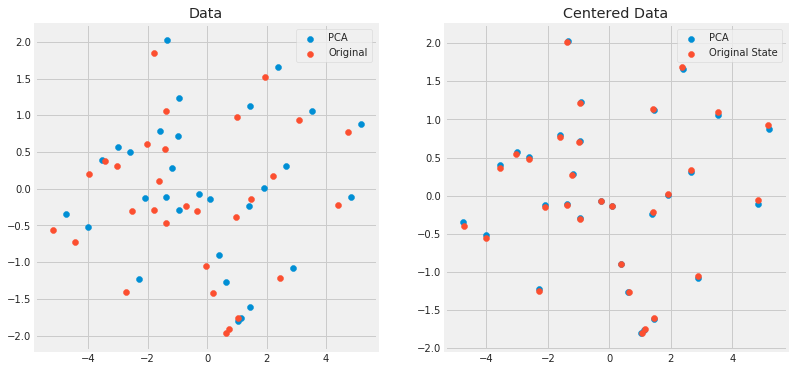

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(*pca.transform(X).T, label='PCA')
axes[0].scatter(*X2.T, label='Original')
axes[0].legend()
axes[0].set_title('Data')
axes[1].scatter(*pca.transform(X).T, label='PCA')
axes[1].scatter(*(X2 - X2.mean(axis=0)).T, label='Original State')
axes[1].legend()
axes[1].set_title('Centered Data')

## 4. More Resources

[INTERACTIVE Principal Component Analysis](http://setosa.io/ev/principal-component-analysis/)

[Dimensionality Reduction: ways and intuitions](https://towardsdatascience.com/dimensionality-reduction-ways-and-intuitions-1b5e97592d8e)

[Dimensionality Reduction for Dummies - Part 1: Intuition](https://towardsdatascience.com/https-medium-com-abdullatif-h-dimensionality-reduction-for-dummies-part-1-a8c9ec7b7e79)

[Dimensionality Reduction for Dummies - Part 2: Laying the Bricks](https://towardsdatascience.com/dimensionality-reduction-for-dummies-part-2-3b1e3490bdc9)

[Dimensionality Reduction For Dummies — Part 3: Connect The Dots](https://towardsdatascience.com/dimensionality-reduction-for-dummies-part-3-f25729f74c0a)

[How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)

[Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap)

#### This material is copyright Daniel Voigt Godoy and made available under the Creative Commons Attribution (CC-BY) license ([link](https://creativecommons.org/licenses/by/4.0/)). 

#### Code is also made available under the MIT License ([link](https://opensource.org/licenses/MIT)).

In [9]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')